In [1]:
# load libraries
import xarray as xr
import numpy as np

from argopy import DataFetcher as ArgoDataFetcher

from datetime import datetime, timedelta
import pandas as pd

import cartopy.crs as ccrs 
import matplotlib.pyplot as plt
import cartopy.feature as cfeature


import time

In [9]:
# User defined functions:
def get_argo_region_data(llon,rlon,llat,ulat,depthmin,depthmax,time_in,time_f):
    
    """Function to get argo data for a given lat,lon box (using Argopy), 
       and return a 2D array collection of vertical profile for the given region
    
    Parameters
    ----------
    llon : int
        left longitude
    rlon : int
        right longtidue
    ulat : int
        upper latitude
    llat : int
        lower latitude
    time_in : str/datetime object
        the start time of desired range, formatted Y-m-d
    time_f : str/datetime object
        the end time of desired range, formatted Y-m-d
    
    
    Returns
    ---------
    xarray
        The result is a xarray of the vertical profile for the given range and region.
        
    
    """

    ds_points = ArgoDataFetcher(src='erddap').region([llon,rlon, llat,ulat, depthmin, depthmax,time_in,time_f]).to_xarray()
    ds_profiles = ds_points.argo.point2profile()
    return ds_profiles


def spliced_argo_region_data(llon,rlon,llat,ulat,depthmin,depthmax,time_start,time_end,dt):
    """Function that gets the argo data for given latitude and longitude bounding box
       (using Argopy), and given start and end time range to return a 2D array collection of vertical
       profile for the given region and time frame
    
    Parameters
    ----------
    llon : int
        left longitude
    rlon : int
        right longtidue
    ulat : int
        upper latitude
    llat : int
        lower latitude
    time_in : str/datetime object
        the start time of desired range, formatted Y-m-d
    time_f : str/datetime object
        the end time of desired range, formatted Y-m-d
    dt: int
        maxmimum number of days 
    
    Returns
    ---------
    xarray
        The result is a xarray of the vertical profile for the given range and region.
        
    
    """

    
    #step
    #dt=dt
    max_dt = timedelta(days = dt)
    
    if isinstance(time_start, str):
        time_start = datetime.strptime(time_start,"%Y-%m-%d")
    if isinstance(time_end, str):
        time_end = datetime.strptime(time_end,"%Y-%m-%d")
        
    if time_end - time_start <= max_dt:
        ds = get_argo_region_data(llon,rlon,llat,ulat,depthmin,depthmax,time_start,time_end)
        return ds
    else:
        early_end = time_start+max_dt
        ds = get_argo_region_data(llon,rlon,llat,ulat,depthmin,depthmax,time_start,early_end)
        time.sleep(0.5)
        print("Retrived data from " + str(time_start) + " to " + str(early_end) + ", retreived " + str(len(ds.N_PROF)) + " profiles")
        ds2 = spliced_argo_region_data(llon,rlon,llat,ulat,depthmin,depthmax, early_end,time_end,dt)
        return xr.concat([ds,ds2],dim='N_PROF')


In [3]:
llon=-70;rlon=22
ulat=10;llat=-70 
depthmin=0;depthmax=1400
time_in='2015-01-01'
time_f='2015-02-01'
ds=get_argo_region_data(llon,rlon,llat,ulat,depthmin,depthmax,time_in,time_f)


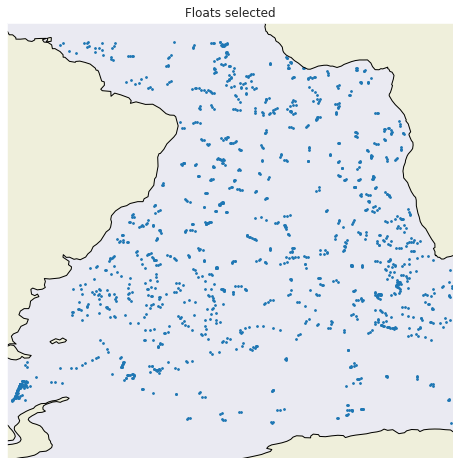

In [4]:
plt.figure(figsize=(15,8))
    
ax = plt.subplot(111, projection=ccrs.PlateCarree()
                 #Mercator()
                 )
ax.set_extent([llon,rlon,llat,ulat])
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
sc = ax.scatter(ds['LONGITUDE'], ds['LATITUDE'], s=3)

plt.title('Floats selected')
plt.show()

In [5]:
ds.to_netcdf('/home/jovyan/ohw20-proj-pyxpcm/data/SA/2015jan.nc')

In [ ]:
llon=-70;rlon=22
ulat=10;llat=-45
depthmin=0;depthmax=1400
time_in='2015-02-01'
time_f='2015-02-13'
ds=get_argo_region_data(llon,rlon,llat,ulat,depthmin,depthmax,time_in,time_f)

In [10]:
llon=-70;rlon=22
ulat=10;llat=-70 
depthmin=0;depthmax=1400
time_start='2015-01-01'
time_end='2015-03-01'
ds=spliced_argo_region_data(llon,rlon,llat,ulat,depthmin,depthmax,time_start,time_end,dt=11)

Retrived data from 2015-01-01 00:00:00 to 2015-01-12 00:00:00, retreived 527 profiles


ClientResponseError: 500, message='Internal Server Error', url=URL('https://www.ifremer.fr/erddap/tabledap/ArgoFloats.nc?data_mode,latitude,longitude,position_qc,time,time_qc,direction,platform_number,cycle_number,pres,temp,psal,pres_qc,temp_qc,psal_qc,pres_adjusted,temp_adjusted,psal_adjusted,pres_adjusted_qc,temp_adjusted_qc,psal_adjusted_qc,pres_adjusted_error,temp_adjusted_error,psal_adjusted_error&longitude%3E=-70&longitude%3C=22&latitude%3E=-70&latitude%3C=10&pres%3E=0&pres%3C=1400&time%3E=1421020800.0&time%3C=1421971200.0&distinct()&orderBy(%22time,pres%22)')

In [ ]:
# Loop over 2014-2019 to get all winter months (jan and feb), and 
years=pd.date_range('2015-01-01','2020-01-01', 
              freq='Y').strftime("%Y").tolist()

# winter (jan-feb)
time_in=pd.date_range('2015-01-01','2019-01-01', 
              freq='YS').strftime("%Y-%m-%d").tolist()
time_f=[#'2014-03-01',
 '2015-03-01',
 '2016-03-01',
 '2017-03-01',
 '2018-03-01',
 '2019-03-01']

llon=-90;rlon=0
ulat=70;llat=0 
depthmin=0;depthmax=1400

for i,year in enumerate(years):
    ds = spliced_argo_region_data(llon,rlon,llat,ulat,depthmin,depthmax,time_in[i],time_f[i])
    ds.to_netcdf(str('/home/jovyan/ohw20-proj-pyxpcm/data/winter'+str(year)+'.nc'))

In [ ]:
# Loop over 2014-2019 to get all summer months (jul and aug), and 
years=pd.date_range('2015-01-01','2020-01-01', 
              freq='Y').strftime("%Y").tolist()

# summer (jul-aug)
time_in=[#'2014-07-01',
 '2015-07-01',
 '2016-07-01',
 '2017-07-01',
 '2018-07-01',
 '2019-07-01']

time_f=[#'2014-09-01',
 '2015-09-01',
 '2016-09-01',
 '2017-09-01',
 '2018-09-01',
 '2019-09-01']

llon=-90;rlon=0
ulat=70;llat=0 
depthmin=0;depthmax=1400

for i,year in enumerate(years):
    ds = spliced_argo_region_data(llon,rlon,llat,ulat,depthmin,depthmax,time_in[i],time_f[i])
    ds.to_netcdf(str('/home/jovyan/ohw20-proj-pyxpcm/data/summer'+str(year)+'.nc'))